## Setup

### Imports

In [67]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torchvision.transforms as transforms
from torchvision.transforms import (
    Resize,
    RandomHorizontalFlip,
    RandomRotation,
    ToTensor,
    Normalize
)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from utils.classifier import OsteoporosisClassifier, evaluate_model
from utils.onnx_triton import export_to_onnx, create_triton_config
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
import os
from pathlib import Path
from PIL import Image
import numpy as np


## Global variables

In [68]:
from utils.classifier import (
    BATCH_SIZE, 
    NUM_WORKERS, 
    IMG_SIZE, 
    NUM_CLASSES, 
    MAX_EPOCHS, 
    LEARNING_RATE, 
    CLASS_NAMES
)

### Dataset collection

In [69]:
# Download latest version
TASK_NAME = 'Osteoporosis Knee X-ray'
path = kagglehub.dataset_download("mohamedgobara/osteoporosis-database")

path = os.path.join(path, TASK_NAME)
print("Path to dataset files:", path)


Path to dataset files: /home/gasyna/.cache/kagglehub/datasets/mohamedgobara/osteoporosis-database/versions/1/Osteoporosis Knee X-ray


## Dataset

In [70]:
class OsteoporosisDataset(Dataset):
    """Custom dataset for Osteoporosis Classification"""

    def __init__(self, dataframe: pd.DataFrame, transform = None):
        # super().__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_map = {label: key for key, label in enumerate(CLASS_NAMES)}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx) -> list[Image.Image, int]:
        img_path = self.dataframe.iloc[idx]['filepaths']
        label    = self.dataframe.iloc[idx]['labels']
        label    = self.label_map[label]

        try:
            # Load image
            image = Image.open(img_path).convert('RGB') # Convert to RGB to better feature extraction
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # return dummy image
            dummy_image = torch.zeros(3, *IMG_SIZE)
            return dummy_image, 0

## Datamodule

In [71]:
class OsteoporosisDataModule(pl.LightningDataModule):
    """ Data module with torchvision transforms and oversampling for imbalanced dataset """
    def __init__(self, data_dir: str, batch_size: int = 4, num_workers: int = 4, img_size: tuple[int, int] = (224, 224)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

        # Data augumentation
        self.train_transform = transforms.Compose([
            Resize(self.img_size),
            RandomHorizontalFlip(p=0.2),
            RandomRotation(degrees=[-15, 15]),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225]) # ImageNet RGB standard deviation for pretrained model
        ])

        self.val_transform = transforms.Compose([
            Resize(self.img_size),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225]) # ImageNet RGB standard deviation for pretrained model
        ])

    def prepare_data(self):
        """ Load and balance data """
        filepaths = []
        labels = []

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.exists(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        filepaths.append(os.path.join(class_dir, filename))
                        labels.append(class_name)

        self.df_full = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
        print(f"Original dataset size: {len(self.df_full)}")
        print(f"Class distribution:\n{self.df_full['labels'].value_counts()}")
    
    def oversample(self, df):
        """ Oversample a DataFrame to balance class distribution """
        max_count = df['labels'].value_counts().max()
        balanced_df = pd.concat([
            group.sample(max_count, replace=True, random_state=42)
            for _, group in df.groupby('labels')
        ]).sample(frac=1, random_state=42).reset_index(drop=True)

        return balanced_df

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            # Split before oversampling
            train_df, temp_df = train_test_split(
                self.df_full, test_size=0.3, stratify=self.df_full['labels'], random_state=42
            )
            self.val_df, self.test_df = train_test_split(
                temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42
            )

            # Now oversample train only
            self.train_df = self.oversample(train_df)
            # self.val_df = self.oversample(self.val_df)

            print("Train/Val/Test sizes:")
            print(f"Train: {len(self.train_df)}")
            print(f"Val: {len(self.val_df)}")
            print(f"Test: {len(self.test_df)}")

        if stage == 'test':
            if not hasattr(self, 'test_df'):
                _, temp_df = train_test_split(self.df_full, test_size=0.3, stratify=self.df_full['labels'], random_state=42)
                _, self.test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)
                # self.test_df = self.oversample(self.test_df)

    def train_dataloader(self):
        train_dataset = OsteoporosisDataset(self.train_df, transform=self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, 
                         shuffle=True, num_workers=self.num_workers, pin_memory=True)
    
    def val_dataloader(self):
        val_dataset = OsteoporosisDataset(self.val_df, transform=self.val_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, 
                         shuffle=False, num_workers=self.num_workers, pin_memory=True)
    
    def test_dataloader(self):
        test_dataset = OsteoporosisDataset(self.test_df, transform=self.val_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, 
                         shuffle=False, num_workers=self.num_workers, pin_memory=True)
    
    def predict_dataloader(self):
        return self.test_dataloader()

## Classifier

In [72]:
# imported from classifier.py

## Trainer

In [ ]:
pl.seed_everything(42)

# Initialize data module
datamodule = OsteoporosisDataModule(
    data_dir=path,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    img_size=IMG_SIZE
)

# Prepare and setup data
print("Preparing balanced dataset...")
datamodule.prepare_data()
datamodule.setup('fit')


model = OsteoporosisClassifier(
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE
)

early_stop = EarlyStopping(
    monitor='val_balanced_acc',
    patience=15,
    mode='max',
    verbose=True
)

checkpoint = ModelCheckpoint(
    monitor='val_balanced_acc',
    dirpath='checkpoints/',
    filename='simple-osteo-{epoch:02d}-{val_balanced_acc:.3f}',
    save_top_k=1,
    mode='max'
)

# Initialize trainer
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop, checkpoint],
    logger=TensorBoardLogger('tb_logs', name='simple_osteoporosis'),
    accelerator='auto',
    devices='auto',
    precision=32  # Use full precision for stability
)

print("Starting training with balanced dataset...")
trainer.fit(model, datamodule=datamodule)

## Evaluation

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating final model...
Original dataset size: 239
Class distribution:
labels
osteopenia      154
osteoporosis     49
normal           36
Name: count, dtype: int64
Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 12.12it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss           0.8823410868644714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Original dataset size: 239
Class distribution:
labels
osteopenia      154
osteoporosis     49
normal           36
Name: count, dtype: int64
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 11.91it/s]

Final Test Results:
              precision    recall  f1-score   support

      Normal       0.75      0.50      0.60         6
  Osteopenia       0.85      0.74      0.79        23
Osteoporosis       0.33      0.57      0.42         7

    accuracy                           0.67     

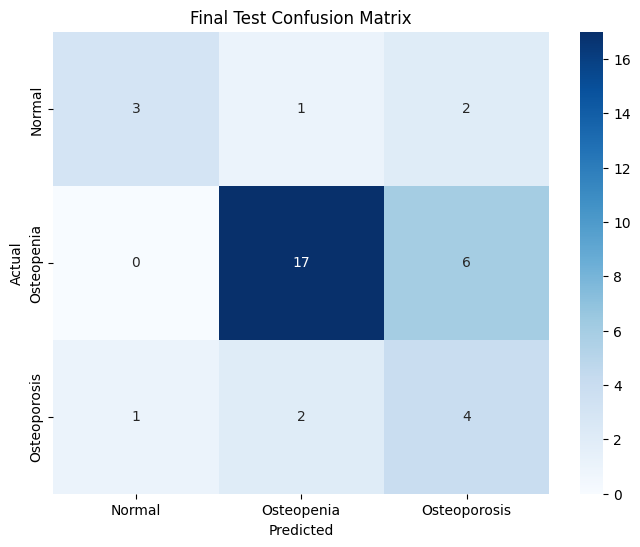


Per-class Performance:
Normal      : Recall=50.0%, Precision=75.0%
Osteopenia  : Recall=73.9%, Precision=85.0%
Osteoporosis: Recall=57.1%, Precision=33.3%


In [74]:
# Load best model and evaluate
best_model = OsteoporosisClassifier.load_from_checkpoint(
    checkpoint.best_model_path,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE
)

print("\nEvaluating final model...")

evaluate_model(trainer, best_model, datamodule)


## Export

In [75]:
export_to_onnx(checkpoint.best_model_path)

Model exported to /home/gasyna/knee_osteoporosis/utils/models/osteoporosis_classifier/1/model.onnx
ONNX model verification successful!
ONNX Runtime test successful! Output shape: (1, 3)


'/home/gasyna/knee_osteoporosis/utils/models/osteoporosis_classifier/1/model.onnx'

## Create Triton config files

In [77]:
create_triton_config()

Triton config created at /home/gasyna/knee_osteoporosis/utils/models/osteoporosis_classifier/config.pbtxt


'/home/gasyna/knee_osteoporosis/utils/models/osteoporosis_classifier/config.pbtxt'